# Spatial DFBA Model

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


## Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from vivarium.core.engine import Engine
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_objective_flux, plot_fields_temporal
from IPython.display import display, HTML
import imageio.v2 as imageio
import io
import base64
import imageio

In [2]:
### XXXXX FIX THIS ISSUE #####
base_directory = '/Users/amin/Desktop/VivaComet'
os.chdir(base_directory)

# Check the current working directory to confirm it's set correctly
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/amin/Desktop/VivaComet


In [3]:
# Configuration
total_time = 1
config = {
    'bounds': [10, 10],  # dimensions of the environment
    'nbins': [10, 10],   # division into bins
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': 'data/Alteromonas_Model.xml',  # Path to FBA model file
            'diffusion_rate': 0.001,
            'advection_vector': (0.0, -0.01),
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 2.0),  # Km, Vmax for glucose
                'oxygen': (0.3, 5.0),   # Km, Vmax for oxygen
            }
        },
        {
            'name': 'ecoli',
            'model': 'data/iECW_1372.xml',  # Path to E. coli model file
            'diffusion_rate': 0.001,
            'advection_vector': (0.0, -0.01),
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 1.5),  # Km, Vmax for glucose
                'oxygen': (0.25, 4.5),  # Km, Vmax for oxygen
            }
        }
    ]
}

# Initialize the process
spatial_dfba = SpatialDFBA(config)
initial_state = spatial_dfba.initial_state({'random': {'glucose': 5.0, 'oxygen': 2.0, 'species': {'ecoli': 0.5, 'Alteromonas': 0.5 }}})

# Create the simulation engine
sim = Engine(
    initial_state=initial_state,
    processes={'spatial_dfba': spatial_dfba},
    topology={'spatial_dfba': {
        'fields': ('fields',),
        'species': ('species',),
        'dimensions': ('dimensions',),
    }}
)

# Run the simulation
sim.update(total_time)

# Get the results
data = sim.emitter.get_timeseries()

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Loaded model for ecoli

Simulation ID: a048edf6-214d-11ef-a3f1-ba21c95c07d8
Created: 06/02/2024 at 22:04:35


/Users/amin/Desktop/VivaComet/myenv/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 6.84 seconds


/var/folders/wc/w8xfpkvd1gq1szrqlrsy0cy40000gn/T/ipykernel_74335/2819736004.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(buf))



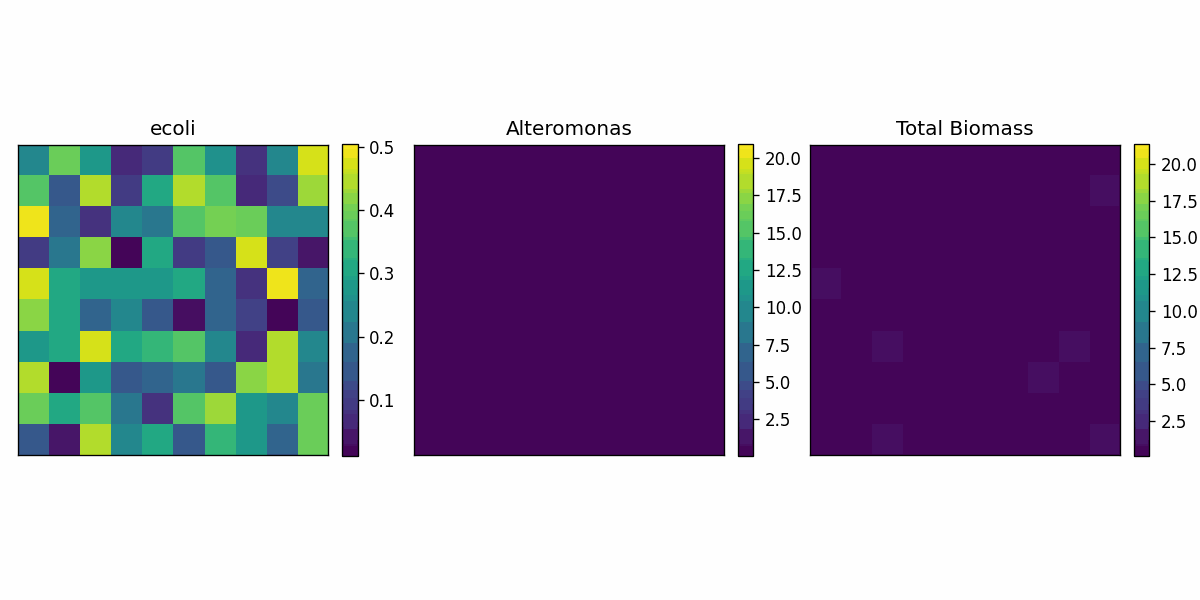

In [12]:
def plot_objective_flux_to_gif(
        data,
        total_time,
        species_names,
        filename='objective_flux_over_time.gif'
):
    available_time_points = data["time"]
    valid_time_points = list(range(total_time + 1))

    num_species = len(species_names)
    num_times = len(valid_time_points)
    images = []

    # Calculate global min and max for each species and total biomass
    global_min = [np.inf] * (num_species + 1)  # +1 for total biomass
    global_max = [-np.inf] * (num_species + 1)

    # Precompute global min/max for species and total biomass
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            global_min[j] = min(global_min[j], np.min(current_species))
            global_max[j] = max(global_max[j], np.max(current_species))

        # Update total biomass global min and max
        global_min[-1] = min(global_min[-1], np.min(total_biomass))
        global_max[-1] = max(global_max[-1], np.max(total_biomass))

    # Plotting each species and total biomass for each time
    for time in valid_time_points:
        time_index = data["time"].index(time)
        total_biomass = np.zeros_like(data["species"][species_names[0]][time_index])
        fig, axs = plt.subplots(1, num_species + 1, figsize=(num_species * 5, 5), squeeze=False)

        for j, species_id in enumerate(species_names):
            current_species = data["species"][species_id][time_index]
            total_biomass += current_species
            im = axs[0, j].imshow(current_species, cmap='viridis', vmin=global_min[j], vmax=global_max[j])
            axs[0, j].set_title(species_id)
            axs[0, j].set_xticks([])
            axs[0, j].set_yticks([])
            plt.colorbar(im, ax=axs[0, j], fraction=0.046, pad=0.04)

        # Plot total biomass in the last column
        im = axs[0, -1].imshow(total_biomass, cmap='viridis', vmin=global_min[-1], vmax=global_max[-1])
        axs[0, -1].set_title("Total Biomass")
        axs[0, -1].set_xticks([])
        axs[0, -1].set_yticks([])
        plt.colorbar(im, ax=axs[0, -1], fraction=0.046, pad=0.04)

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
        plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Objective Flux Over Time" style="max-width:100%;"/>'))

# Example usage
# Ensure to use time points that exist in your data
plot_objective_flux_to_gif(data, total_time=1, species_names=['ecoli', 'Alteromonas'])

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Display the GIF
#display_gif('objective_flux_over_time.gif')
